When a user watches the movie, either they like it or they don't like it. The below notebook experiments various algorithms to recommend a movie based on user choice, and explains which algorithm is better.

In this experiment, we considered 13 basic genre of the movie as the arms in bandit

"Action, Crime, Drama, Fantasy, Horror, Comedy, Romance, Science Fiction, Sports, Thriller, Mystery, War, and Western"


In [281]:
pip install autopep8

Note: you may need to restart the kernel to use updated packages.


In [282]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

In [283]:
stationary=True
class Bandit():
    
    def __init__(self, arm_count):
        """
        Multi-armed bandit with rewards 1 or 0.
    
        At initialization, multiple arms are created. The probability of each arm
        returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
        chosen from Uniform(0,1) at initialization
        """
        self.arm_count = arm_count
        self.generate_thetas()
        self.timestep = 0
        global stationary
        self.stationary=stationary
    
    def generate_thetas(self):
        if arm_count == 12:
            self.thetas = np.asarray([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.9])
        elif arm_count == 11:
            self.thetas = np.asarray([0.5,0.5,0.6,0.7,0.7,0.6,0.5,0.7,0.5,0.7,0.6])
        else:
            self.thetas = np.random.uniform(0,1,self.arm_count)
  
    def get_reward_regret(self, arm):
        """ Returns random reward for arm action. Assumes actions are 0-indexed
        Args:
          arm is an int
        """
        self.timestep += 1
        if (self.stationary==False) and (self.timestep%100 == 0) :
            self.generate_thetas()
        # Simulate bernouilli sampling
        sim = np.random.uniform(0,1,self.arm_count)
        rewards = (sim<self.thetas).astype(int)
        reward = rewards[arm]
        regret = self.thetas.max() - self.thetas[arm]
    
        return reward, regret

In [284]:
class BetaAlgo():
    """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
    def __init__(self, bandit):
        """
        Args:
        bandit: the bandit class the algo is trying to model
        """
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward


In [285]:
epsilon = 0.1
class EpsilonGreedy():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """
    def __init__(self, bandit):
        global epsilon
        self.epsilon = epsilon
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count) # q-value of actions
        self.N = np.zeros(self.arm_count) # action count

    @staticmethod
    def name():
        return 'epsilon-greedy'

    def get_action(self):
        if np.random.uniform(0,1) > self.epsilon:
            action = self.Q.argmax()
        else:
            action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule


In [286]:
ucb_c = 2
class UCB():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """
    def __init__(self, bandit):
        global ucb_c
        self.ucb_c = ucb_c
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count) # q-value of actions
        self.N = np.zeros(self.arm_count) + 0.0001 # action count
        self.timestep = 1
  
    @staticmethod
    def name():
        return 'ucb'
  
    def get_action(self):
        ln_timestep = np.log(np.full(self.arm_count, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        return action
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [287]:
class normal_thompson_sampling():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)
        self.mean = np.ones(self.arm_count)
        self.stdeviation = np.ones(self.arm_count)
        
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward
        self.mean = self.alpha/(self.alpha + self.beta)
        self.stdeviation = (self.alpha * self.beta)/((self.alpha + self.beta)**2 * (self.alpha + self.beta +1))

    @staticmethod
    def name():
        return 'NTS' # NTS - Thompson sampling using Normal distribution
  
    def get_action(self):
        theta = np.random.normal(self.mean, self.stdeviation)
        return theta.argmax()
    

In [288]:
class random_sampling():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        
    @staticmethod
    def name():
        return 'random'
    
    def get_action(self):
#         theta = np.random.random_sample(self.arm_count)
        theta = np.random.rand(self.arm_count)
        return theta.argmax()
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret
    
        

In [289]:
class bern_thompson_sampling(BetaAlgo):
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)

    @staticmethod
    def name():
        return 'thompson beta'
  
    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""
        theta = np.random.beta(self.alpha, self.beta)
        return theta.argmax()

In [290]:
def plot_data(y):
    """ y is a 1D vector """
    x = np.arange(y.size)
    _ = plt.plot(x, y, 'o')

def multi_plot_data(data, names):
    """ data, names are lists of vectors """
    x = np.arange(data[0].size)
    for i, y in enumerate(data):
        plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
    plt.show()
    
def simulate(simulations, timesteps, arm_count, Algorithm):
    """ Simulates the algorithm over 'simulations' epochs """
    sum_regrets = np.zeros(timesteps)
    for e in range(simulations):
        bandit = Bandit(arm_count)
        algo = Algorithm(bandit)
        regrets = np.zeros(timesteps)
        for i in range(timesteps):
            action = algo.get_action()
            reward, regret = algo.get_reward_regret(action)
            regrets[i] = regret
        sum_regrets += regrets  
    mean_regrets = sum_regrets / simulations
    return mean_regrets


def experiment(arm_count, timesteps=1000, simulations=1000):
    """
    Standard setup across all experiments 
      Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
    """
    algos = [bern_thompson_sampling, random_sampling, normal_thompson_sampling, EpsilonGreedy, UCB]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

Q.1) Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important

Thompson Sampling : It is dependent on the paramenters - mean, variance, alpha (shape parameter), beta (scale parameter). As per theory and available online resources, as alpha tends to infinity and beta tend to zero, the regret curve goes straight up. It can be seen from experiment number 2nd, if the value of mean is overestimated then the regret curve becomes steeper even before the exploration starts. So, it can be concluded that overestimating mean value, underestimating variance, or changinf the alpha beta value to larger extent affects the exploratory behaviour. Ideal value of alpha, beta = 1,1 works well.

e-greedy is affected by the choice of epsilon value. By decreasing the epsilon value, the greedy algorithm improves marginally as compared to our baseline conditions.

UCB is affected by change in its constant value ucb_c which on decreasing outperforms the thompsom after certain steps as shown in experiment 4 and converges with thompson sampling after 300 steps.

Random sampling is affected by over/underestimated mean. It only decreases the regret value for particular experiment,but remains constant.

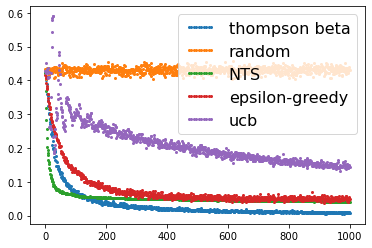

In [291]:
# Experiment 1 : with keeping the baseline values intact

arm_count = 13 # number of arms in bandit (genre of the movie)
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

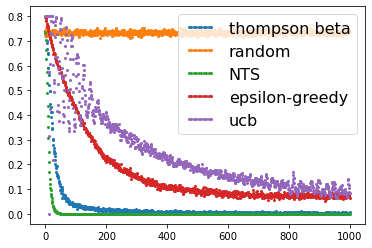

In [292]:
# Experiment 2 : testing by keeping probability distribution fixed with relatively big difference

arm_count = 12 # number of arms in bandit (genre of the movie)
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

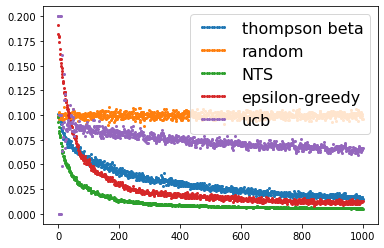

In [293]:
# Experiment 3 : testing by keeping probability distribution fixed with relatively small difference

arm_count = 11 # number of arms in bandit (genre of the movie)
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

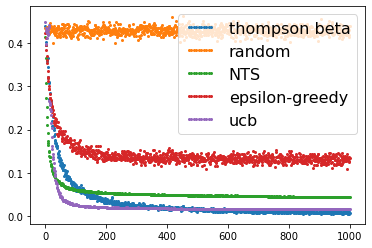

In [294]:
# Experiment 4 : changing value of epsilon

arm_count = 13 # number of arms in bandit
epsilon = 0.3
ucb_c = 0.1
stationary=True
experiment(arm_count)


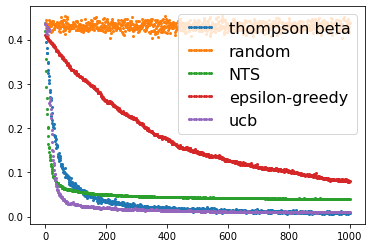

In [295]:
# Experiment 5 : changing value of ucb constant ucb_c

arm_count = 13
epsilon = 0.01
ucb_c = 0.2
stationary=True
experiment(arm_count)

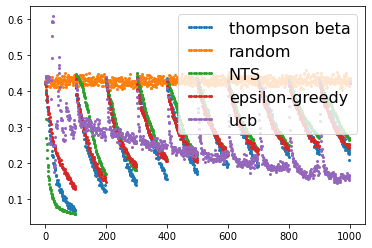

In [296]:
# Experiment 6 : changing value of stationary to "False"
arm_count = 13
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

Q.2) How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. 

As can be seen in expriment 8, with increase in action space,

Thompson sampling : slowly decreases the regret value and outperforms all the algorithms after 950 steps.
Random smapling remains unaffected
E-greedy's regret value has been improved comparatively and become stable after 200 steps
UCB becomes untable with increase in action space. But for assertion, more number of experiment is required.

Q.3) How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. 

Below we can see after changing the value of stationary to false, the regret value starts exploring after every 100 steps and
performs poorly as the true reward distribution changes over time. Although the values of thompson and e-greedy decreases in the beginning and then slowly increase the regret value. The ucb constantly decrease the regret value. Random sampling remains unaffected.

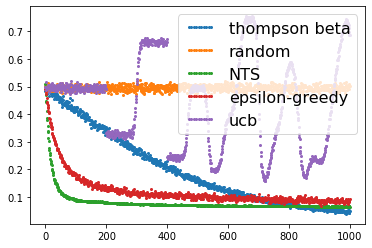

In [297]:
# Experiment 7 : Large number of arms

arm_count = 200
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

Q.4) When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff

As per the experiment 8 shown below, the graph indicates that if the number of rounds are increased to 10000 and simulation is maintained 1000, the Thompson sampling performs much better and outperforms UCB and e-greedy algorithm. We can also see that the all three graphs are converging at the end.
Trade off between exploration expxloitation is usually defined as the dilemma of choosing an information between exploitation (information that you and the information that you expect to get) and exploration (infomration that you are not sure about and then learning more). In e-greedy the hyperparameter can be adjusted to gain that trade off but this is not an ideal approach. UCB stops exploring when the confidence bound decrease and becomes smaller with each round of exploration and exploitation.

Q.5) How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer.

After the certain number of exploration steps, i.e. in the range of 200-300, the algorithms shows results on what they learnt from the experimentation. This shows that the past actions are remembered and learnt. Random sampling keeps exploring despite the change in action as we can see in experiment 9. In the graph shown, we can observe that after 700 steps, UCB value reaches 0 before again increasing near 800 steps. Thompson sampling keeps exploring till the end constantly decreasing regret value and reaching to almost 0.0. Epsilon greedy value is not less than 0.1.

Q.6) Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

After modifying the thompson sampling for normal distribution, and changing different parameters, it can be concluded that thompson beta distribution is better than normal distribution when there is uncertainty about the probaility of success. And this is proved via all the graphs plotted.

Q.7) What code is yours and what have you adapted? 
I have referred and adapted the thompson.ipynb notebook given in the question, and added the code for thompson sampling normal distribution, random sampling, and fixed probability distribution to check the effect of hyperparameters in thompson sampling. Other references are mentioned in References section.
For a testing purpose I tried pareto distribution and tried applying inverse gamma distribution but haven't succeeded. I'm still working on it.

References

https://medium.com/analytics-vidhya/multi-armed-bandit-analysis-of-thompson-sampling-algorithm-6375271f40d1
https://gertjanvandenburg.com/blog/thompson_sampling/
https://github.com/ankonzoid/LearningX/blob/master/classical_RL/multiarmed_bandit/multiarmed_bandit.py
https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb
https://arxiv.org/pdf/1707.02038.pdf?ref=hackernoon.com

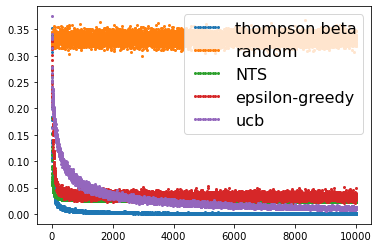

In [298]:
# Experiment 8
arm_count = 13 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count,timesteps=10000, simulations=1000)

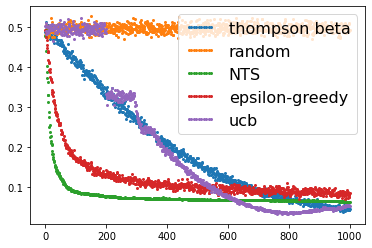

In [299]:
# Experiment 9 : Large number of arms with change in baseline conditions

arm_count = 200
epsilon = 0.1
ucb_c = 0.2
stationary=True
experiment(arm_count)